In [529]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image


In [530]:
labels = pd.read_csv('labels.txt',index_col=0,names=['ID','Label'])

In [531]:
labels

,Label
ID,
0,0
1,0
2,0
3,0
4,0
...,...
558,0
559,0
560,0


In [532]:
labels.value_counts()

Label
0        482
1         40
2         23
3         18
dtype: int64

### 0 label are unlabeled images

In [533]:
labels = labels[labels.Label != 0]

In [534]:
labels

,Label
ID,
25,1
87,1
98,1
105,2
106,1
...,...
536,1
538,1
544,2


## Plot cells

In [535]:
selected_rows = labels.groupby('Label').sample(n=3)

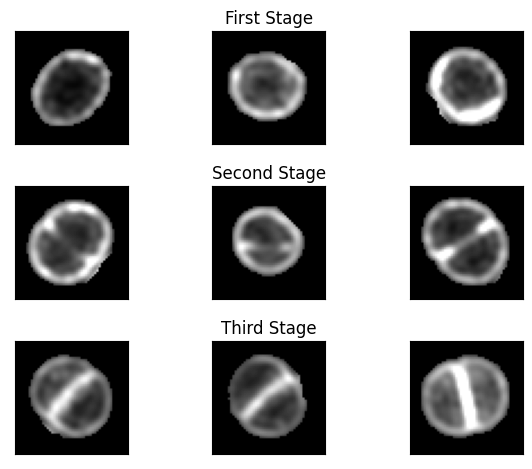

In [536]:
fig, axs = plt.subplots(3,3)
for id,ax in enumerate(axs.flatten()):
    row = selected_rows.iloc[id]
    ax.imshow(Image.open('images\{i}.png'.format(i=row.name)),cmap="gray")
    ax.set_label(row.Label)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0, 1].set_title('First Stage')
axs[1, 1].set_title('Second Stage')
axs[2, 1].set_title('Third Stage')
plt.tight_layout()
plt.show()

## Load Images

In [537]:
images = []
for l in labels.index:
    images.append(np.asarray(Image.open('images\{i}.png'.format(i=l))).flatten())

images = np.array(images)/255

# Extract Features

#### TSNE Features

In [538]:
from sklearn.decomposition import PCA

In [539]:
pca = PCA(6).fit_transform(images)

#### t-SNE Features

In [540]:
from sklearn.manifold import TSNE

In [541]:
tsne = TSNE(n_components=6,method='exact').fit_transform(images)

#### Isomap Features

In [542]:
from sklearn.manifold import Isomap

In [543]:
iso = Isomap(n_components=6).fit_transform(images)

#### Join All

In [544]:
merged = np.concatenate((pca, tsne, iso), axis=1)

In [545]:
merged

array([[ 7.32878409,  0.12069747, -1.22886362, ...,  0.72540967,
        -6.11467771, -2.16860722],
       [ 5.51059368,  0.38099209, -0.98888137, ...,  6.60809505,
         1.52090028,  3.01776291],
       [ 6.11283535,  1.10462519, -1.34416947, ...,  0.30137577,
        -5.15877286, -3.10618068],
       ...,
       [-5.19404942,  4.45640759, -2.80782767, ..., -2.91625897,
        -5.48753843, -5.6348135 ],
       [-5.77390024, -1.47335497,  3.77162513, ...,  7.58811385,
        -3.69717294,  0.73682097],
       [-3.28108496,  6.6656022 , -3.01675117, ...,  6.82463455,
         5.60535549, -5.69009789]])

In [546]:
merged= pd.DataFrame(merged,
                     columns=['PCA_1','PCA_2','PCA_3','PCA_4','PCA_5','PCA_6','TSNE_1','TSNE_2','TSNE_3','TSNE_4','TSNE_5','TSNE_6','ISO_1','ISO_2','ISO_3','ISO_4','ISO_5','ISO_6'],
                     index=labels.index)

In [547]:
data = pd.concat([labels,merged],axis=1)

## Standardize and Split Data

In [548]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [549]:
y = data.Label-1
X = data.drop('Label',axis=1)

In [550]:
X_standard = StandardScaler().fit_transform(X)

In [551]:
X_train, X_test, y_train, y_test = train_test_split(X_standard, y,test_size=0.2, stratify=y)

# Train Classifier

In [552]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


In [553]:
xgb_cl = xgb.XGBClassifier()

In [564]:
param_grid = {
    "max_depth": [1, 2, 3, 4, 5, 7],
    "learning_rate": [0.5, 0.1, 0.05, 0.01, 0.005, 0.001],
    "gamma": [0, 0.1, 0.25, 1, 3, 5, 7],
    "reg_lambda": [0, 0.01, 0.1, 1, 10],
}

In [565]:
xgb_cl = xgb.XGBClassifier()
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3)

_ = grid_cv.fit(X_train, y_train)

In [566]:
grid_cv.best_score_

0.7806637806637807

In [567]:
grid_cv.best_params_

{'gamma': 0, 'learning_rate': 0.005, 'max_depth': 3, 'reg_lambda': 10}

In [568]:
final_cl = xgb.XGBClassifier(
    **grid_cv.best_params_,
)

_ = final_cl.fit(X_train, y_train)

# Test Classifier

In [569]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [570]:
roc_auc = roc_auc_score(y_test, final_cl.predict_proba(X_test), multi_class='ovo')
roc_auc

0.9791666666666666

In [571]:
accuracy = accuracy_score(y_test, final_cl.predict(X_test))
accuracy

0.8235294117647058

In [572]:
final_cl.predict(X_test)

array([1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 1, 0, 2, 2, 2, 1, 2], dtype=int64)

In [575]:
np.array(y_test)

array([1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2], dtype=int64)

# Pipelining Everything

In [587]:
from sklearn.pipeline import FunctionTransformer, Pipeline

def featureExtraction(data,n_features=6):
    pca = PCA(n_features).fit_transform(data)
    tsne = TSNE(n_features,method='exact').fit_transform(data)
    iso = Isomap(n_components=n_features).fit_transform(data)
    return np.concatenate((pca, tsne, iso), axis=1)

feature_extraction = Pipeline(steps=[
    ('custom', FunctionTransformer(featureExtraction)),
    ('std',  StandardScaler())
])

feature_extraction.fit_transform(images)

array([[ 2.07681698,  0.0381289 , -0.39938279, ...,  0.13310151,
        -1.38265541, -0.67355607],
       [ 1.56158162,  0.12035721, -0.32138814, ...,  1.21248371,
         0.34390709,  0.93729861],
       [ 1.73224373,  0.34895635, -0.43685739, ...,  0.05529782,
        -1.1665055 , -0.96476062],
       ...,
       [-1.4718799 ,  1.40780036, -0.91254882, ..., -0.53508863,
        -1.24084621, -1.75013844],
       [-1.63619693, -0.46543984,  1.22578465, ...,  1.39230207,
        -0.83600746,  0.22885206],
       [-0.92978765,  2.10569544, -0.98044932, ...,  1.25221538,
         1.26748709, -1.76730943]])